<a href="https://colab.research.google.com/github/cedamusk/fun-projects/blob/main/Magma_Chamber_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [27]:
class GeoParameters:
  def __init__(self):
    self.grid_size=(100, 100,50) #x, y, z dimensions
    self.rock_types={
        'basalt': {'permeability': 1e-15, 'porosity': 0.05, 'density':2900, 'heat_capacity':1000},
        'granite':{'permeability':1e-18, 'porosity':0.01, 'density':2700, 'heat_capacity':850},
        'sediment':{'permeability':1e-14, 'porosity':0.2, 'density':2400, 'heat_capacity':920}
    }
    self.temperature_gradient=25 #degress/km
    self.base_temperature=500 #Degrees at the bottom
    self.surface_temperature=20 #degrees
    self.magma_viscosity=1000 #Pa.s
    self.magma_density=2600 #kg/m3
    self.gravity=9.81
    self.time_steps=100
    self.dt=86400 #Seconds (1 day)


In [28]:
def generate_synthetic_geology(params):
  geology=np.zeros(params.grid_size, dtype=np.int8)

  for z in range(params.grid_size[2]):
    if z < params.grid_size[2]*0.2: #Top 20- sedimentary
      geology[:, :, z]=2
    elif z < params.grid_size[2]*0.6: #Middle-granite
      geology[:, :, z]=1
    else: #Bottom 40%-basalt
      geology[:, :, z]=0

  #Add somerandom variations and intrusions
  noise=np.random.normal(0, 1, params.grid_size)
  noise=gaussian_filter(noise, sigma=3)

  #Createfault lines
  fault_x=int(params.grid_size[0]*0.6)
  fault_offset=int(params.grid_size[2]*0.1)
  for x in range(fault_x, params.grid_size[0]):
    for y in range(params.grid_size[1]):
      for z in range(params.grid_size[2]-fault_offset):
        if z+ fault_offset < params.grid_size[2]:
          geology[x, y, z]=geology[x, y, z + fault_offset]

  #Create magma chamber (simple ellipsoid)
  center=(int(params.grid_size[0]*0.4), int(params.grid_size[1]*0.5), int(params.grid_size[2]*0.7))
  radii=(int(params.grid_size[0]*0.15), int(params.grid_size[1]*0.15), int(params.grid_size[2]*0.1))

  x, y, z=np.ogrid[:params.grid_size[0], :params.grid_size[1], :params.grid_size[2]]

  #Calculate normalized distance from center
  dist=((x-center[0])**2/ radii[0]**2+
        (y-center[1])**2/ radii[1]**2+
        (z-center[2])**2/ radii[2]**2)

  #points inside the ellipsois (dist<1) are magma
  magma_mask=dist<1
  geology[magma_mask]=3

  return geology, magma_mask

In [29]:
def initialize_temperature(params, geology):
  #Basic temperature gradient
  z=np.linspace(0, 1, params.grid_size[2])
  base_temp=np.linspace(params.surface_temperature, params.base_temperature, params.grid_size[2])

  #Initialize temperature grid
  temperature=np.zeros(params.grid_size)

  #Apply basic temperature gradient with depth
  for i in range(params.grid_size[2]):
    temperature[:, :, i]=base_temp[i]

  #Add higher temperature for magma chamber
  magma_mask=geology==3
  temperature[magma_mask]=1200 #Magma temperature in degrees

  #Add some variations
  noise=np.random.normal(0, 10, params.grid_size)
  temperature+=gaussian_filter(noise, sigma=5)

  return temperature

In [30]:
def calculate_permeability(params, geology):
  permeability=np.zeros(params.grid_size)

  rock_perm_values=[
      params.rock_types['basalt']['permeability'],
      params.rock_types['granite']['permeability'],
      params.rock_types['sediment']['permeability'],
      1e-12 #Magma permeability (high to allow flow)
  ]

  for i, perm in enumerate(rock_perm_values):
    permeability[geology==i]=perm

  return permeability

In [31]:
def simulate_magma_flow(params, geology, temperature, permeability):
  #Initialize magma fraction (0=no magma, 1=all magma)
  magma_fraction=np.zeros(params.grid_size)
  magma_fraction[geology==3]=1.0

  #history for visualization
  history=[magma_fraction.copy()]
  temp_history=[temperature.copy()]

  #Simplified pressure calculation
  def calculate_pressure(depth):
    return params.gravity*params.magma_density*depth

  #main simulation loop
  for t in range(params.time_steps):
    #Create pressure field
    pressure=np.zeros(params.grid_size)
    for z in range(params.grid_size[2]):
      depth=(params.grid_size[2]-z)*100 #Depth in meters
      pressure[:, :, z]=calculate_pressure(depth)

    #add overpressure in magma chamber
    pressure[geology==3]*=1.2 #20% overpressure in chamber

    #Calculate velocity field using Darcy's law
    #u=-(k.U)deltap
    velocity=np.zeros((3, *params.grid_size)) #3D vector field

    #calculate pressure gradients (simplified)
    grad_p_x=np.zeros(params.grid_size)
    grad_p_y=np.zeros(params.grid_size)
    grad_p_z=np.zeros(params.grid_size)

    #Finite difference for gradients
    grad_p_x[1:-1, :, :]=(pressure[2:, :, :]-pressure[:-2, :, :])/2
    grad_p_y[:, 1:-1, :]=(pressure[:, 2:, :]-pressure[:, :-2, :])/2
    grad_p_z[:, :, 1:-1]=(pressure[:, :, 2:]-pressure[:, :, :-2])/2

    #Darcy's law
    velocity[0]=-permeability*grad_p_x/ params.magma_viscosity
    velocity[1]=-permeability*grad_p_y/params.magma_viscosity
    velocity[2]=-permeability*grad_p_z/ params.magma_viscosity

    #Add bouyancy effects (simplified)
    bouyancy=np.zeros(params.grid_size)
    for z in range(params.grid_size[2]):
      bouyancy[:, :, z]=(params.grid_size[2]-z)/params.grid_size[2]

    #Apply bouyancy to vertical velocity
    velocity[2]+=1e-7*bouyancy*magma_fraction

    #Update magma fraction using advection (simplified)
    new_magma_fraction=magma_fraction.copy()

    #Very simplified advection
    for i in range(1, params.grid_size[0]-1):
      for j in range(1, params.grid_size[1]-1):
        for k in range(1, params.grid_size[2]-1):
          #Skip if no magma or solid rock
          if magma_fraction[i, j, k]<0.01 or geology [i, j, k] in [0, 1]:
            continue

            #Calculate flow
            flow_x=velocity[0][i, j, k]*params.dt
            flow_y=velocity[1][i, j, k]*params.dt
            flow_z=velocity[2][i, j, k]*params.dt

            #AMount of magma to move
            amount=magma_fraction[i, j, k]*0.1 #Move 10% of magma

            #Update magma fraction based on flow
            if flow_x >0 and i< params.grid_size[0]-1:
              new_magma_fraction[i, j, k]-=amount* abs(flow_x)
              new_magma_fraction[i+1, j, k]+=amount*abs(flow_x)
            elif flow_x<0 and i>0:
              new_magma_fraction[i, j, k]-=amount*abs(flow_x)
              new_magms_fraction[i-1, j, k]+=amount*abs(flow_x)

            if flow_y>0 and j<params.grid_size[1]-1:
              new_magma_fraction[i, j, k]-=amount*abs(flow_y)
              new_magma_fraction[i, j+1, k]+=amount*abs(flow_y)
            elif flow_y <0 and j>0:
              new_magma_fraction[i, j, k]-=amount*abs(flow_y)
              new_magma_fraction[i, j-1, k]+=amount*abs(flow_y)

            if flow_z>0 and k< params.grid_size[2]-1:
              new_magma_fraction[i, j, k]-=amount*abs(flow_z)
              new_magma_fraction[i, j, k+1]+=amount*abs(flow_z)
            elif flow_z<0 and k>0:
              new_magma_fraction[i, j, k]-=amount*abs(flow_z)
              new_magma_fraction[i, j, k-1]+=amount*abs(flow_z)


    #magma cools and solidifies
    new_temperature=temperature.copy()

    cooling_mask=(new_temperature <800)& (new_magma_fraction>0)
    new_magma_fraction[cooling_mask]*=0.9 #Solidification

    #Update states
    magma_fraction=new_magma_fraction
    temperature=new_temperature

    if t% 10==0: #Save every 10 timesteps
      history.append(magma_fraction.copy())
      temp_history.append(temperature.copy())
      print(f"Timestep {t}: Max magma fraction={np.max(magma_fraction):.4f}")

  return history, temp_history


In [32]:
def visualize_results(params, geology, history, temp_history):
  #Create slices for visualziation
  x_slice=params.grid_size[0]//2
  y_slice=params.grid_size[1]//2

  timesteps_to_show=min(5, len(history))

  plt.figure(figsize=(15, 10))
  for t in range(timesteps_to_show):
    idx=t*(len(history)-1)//(timesteps_to_show-1)

    plt.subplot(2, timesteps_to_show, t+1)
    plt.imshow(history[idx][:, y_slice, :].T, origin='lower', cmap='magma', vmin=0, vmax=1)
    plt.title(f'Magma Fraction (t={idx})')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.colorbar(label='Magma Fraction')

    plt.subplot(2, timesteps_to_show, timesteps_to_show+t+1)
    plt.imshow(temp_history[idx][:, y_slice, :].T, origin='lower', cmap='hot', vmin=20, vmax=1200)
    plt.title(f'Temperature (t={idx})')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.colorbar(label='Temperature')

  plt.tight_layout()
  plt.savefig('magma_simulation_results.png')
  plt.show()

  #3D visualization of final state
  fig=plt.figure(figsize=(10, 8))
  ax=fig.add_subplot(111, projection='3d')

  #plot magma as points where concentration>threshold
  final_magma=history[-1]
  threshold=0.3
  x, y, z=np.where(final_magma>threshold)

  #REduce the number of points for better visualization
  skip=2
  x, y, z=x[::skip], y[::skip], z[::skip]
  colors=final_magma[x, y, z]

  scatter=ax.scatter(x, y, z, c=colors, cmap='magma', alpha=0.6, s=10)
  plt.colorbar(scatter, label='Magma Fraction')

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title('3D Magma Distribution')

  plt.savefig('magma_3d_visualization.png')
  plt.show()


In [33]:
def export_for_blender(params, history, filename='magma_data_for_blender.csv'):
  final_magma=history[-1]

  #Create a csv file with coordinates and magma fraction
  with open(filename, 'w')as f:
    f.write("x, y, z, magma_fraction\n")
    for i in range(params.grid_size[0]):
      for j in range(params.grid_size[1]):
        for k in range(params.grid_size[2]):
          if final_magma[i, j, k]>0.1: #Only export significant magma presence
            f.write(f"{i}, {j}, {k}, {final_magma[i, j, k]}\n")

  print(f"Data exported to {filename} for Blender import")


In [34]:
def main():
  params=GeoParameters()
  print("Generating synthetic geology...")
  geology, magma_mask=generate_synthetic_geology(params)

  print("Initializing temperature field...")
  temperature =initialize_temperature(params, geology)

  print("Calculating permeability...")
  permeability=calculate_permeability(params, geology)

  print("Running magma flow simulation...")
  history, temp_history=simulate_magma_flow(params, geology, temperature, permeability)

  print("Visualizing results...")
  visualize_results(params, geology, history, temp_history)

  print("Exporting data for blender...")
  export_for_blender(params, history)

Generating synthetic geology...
Initializing temperature field...
Calculating permeability...
Running magma flow simulation...
Timestep 0: Max magma fraction=1.0000
Timestep 10: Max magma fraction=1.0000
Timestep 20: Max magma fraction=1.0000
Timestep 30: Max magma fraction=1.0000
Timestep 40: Max magma fraction=1.0000
Timestep 50: Max magma fraction=1.0000
Timestep 60: Max magma fraction=1.0000
Timestep 70: Max magma fraction=1.0000
Timestep 80: Max magma fraction=1.0000
Timestep 90: Max magma fraction=1.0000
Visualizing results...


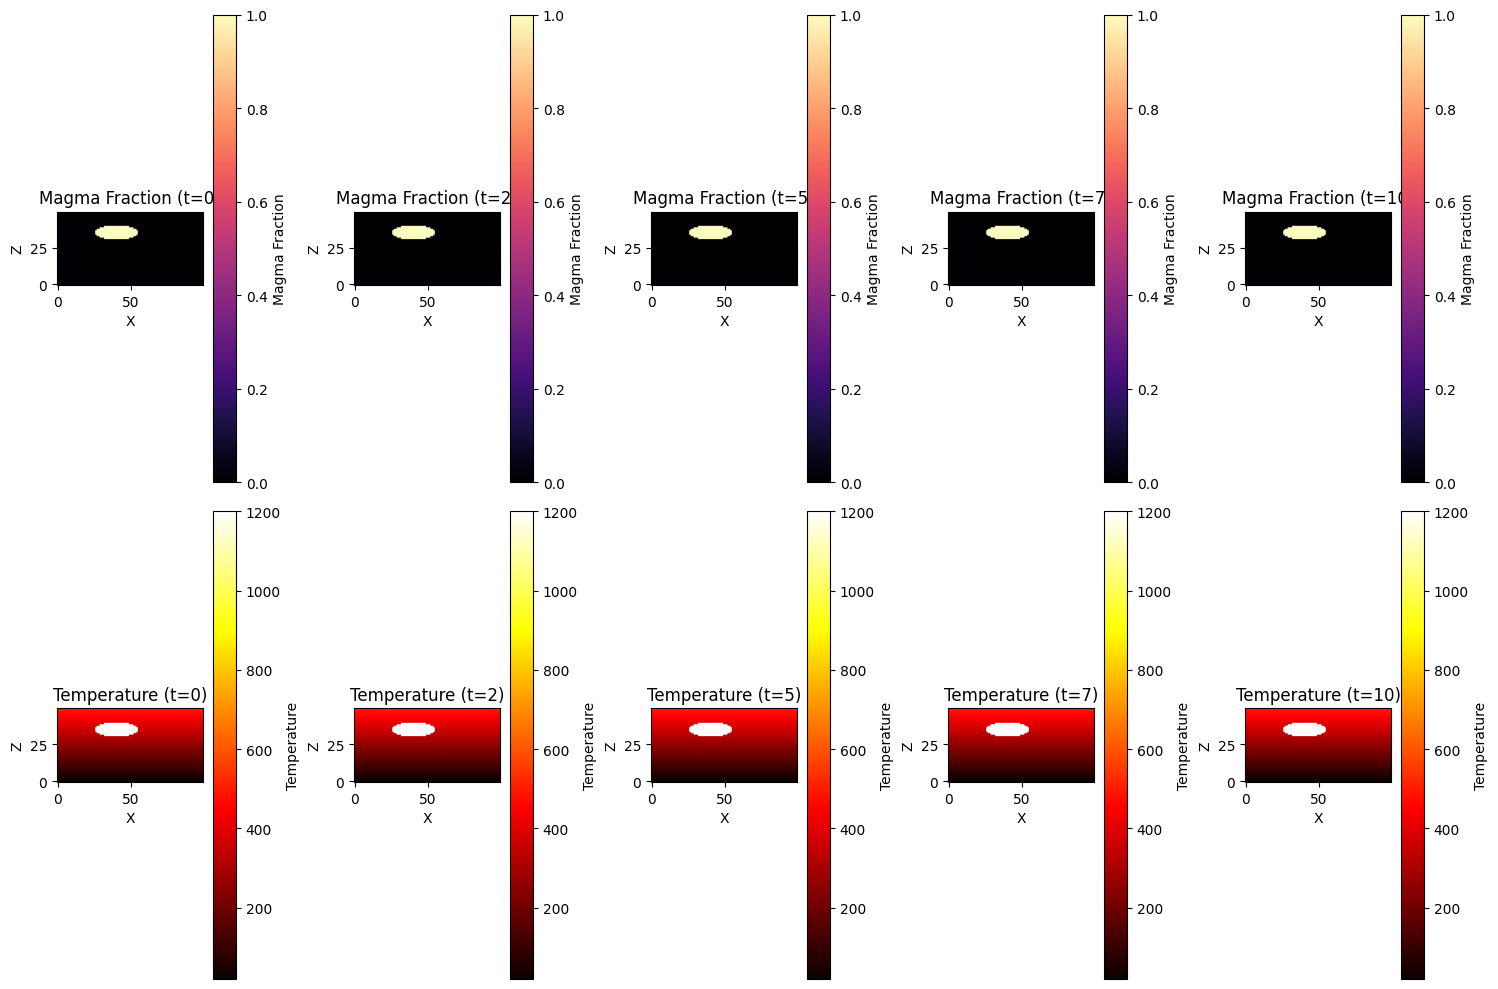

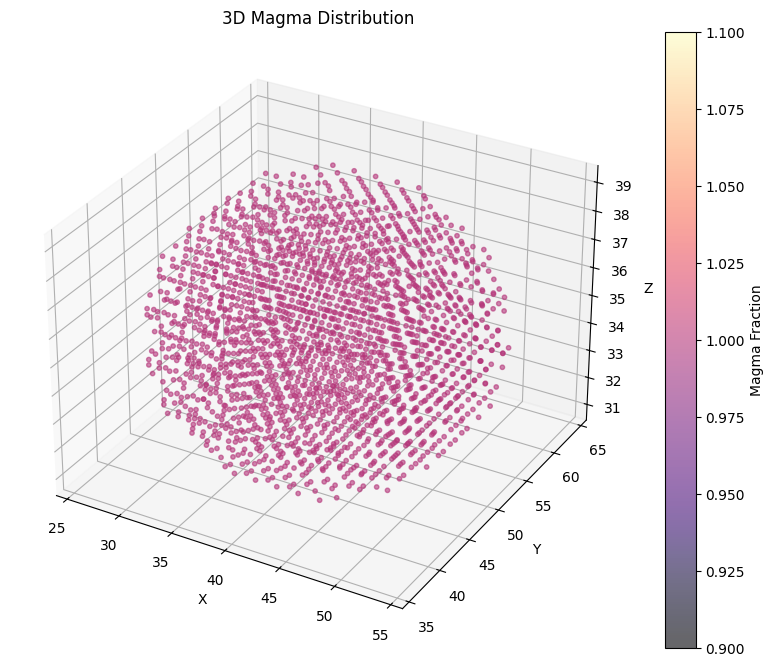

Exporting data for blender...
Data exported to magma_data_for_blender.csv for Blender import


In [35]:
if __name__=="__main__":
  main()